# DenseNet

In [2]:
#torch
import torch 
import torch.nn as nn
import torch.optim as optim  
import torchvision

import torchvision.transforms as transforms
import torch.nn.functional as F
from torchvision.transforms import Compose, ToTensor, Resize
from torchvision.datasets import ImageFolder
from torch.utils.data import (
    Dataset,
    DataLoader,
    Subset
) 

# other
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
import warnings
from skimage import io
# from PIL import Image
import time

warnings.filterwarnings("ignore")

from helper_evaluation import set_all_seeds, set_deterministic, compute_confusion_matrix
from helper_train import train_model
from helper_plotting import plot_training_loss, plot_accuracy, show_examples, plot_confusion_matrix
from helper_dataset import get_dataloaders_cifar10, UnNormalize

from data_loading_functions import split_train_test_loaders, show_img

In [3]:
dataset_path = '.\\Combined_data'
datas, train_loader, valid_loader, test_loader = split_train_test_loaders(dataset_path)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


train_data
actual labels: ['Lung_Opacity', 'Normal', 'Lung_Opacity', 'Lung_Opacity']
numerical labels: tensor([1, 2, 1, 1])


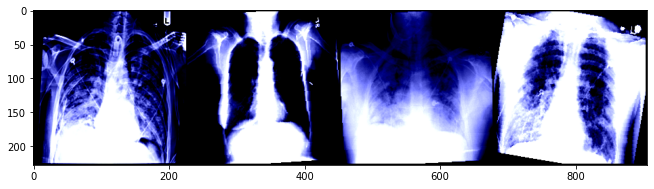

In [4]:
print('train_data')
show_img(datas[0])

In [5]:
print(f'Length of Training: {len(datas[0])}')
print(f'Length of Validation: {len(datas[1])}')
print(f'Length of Testing: {len(datas[2])}')

Length of Training: 21658
Length of Validation: 2708
Length of Testing: 2707


# Load Pretrained DenseNet Model

In [6]:
# Hyperparameters
RANDOM_SEED = 1
LEARNING_RATE = 0.0005
BATCH_SIZE = 64
NUM_EPOCHS = 25

# Architecture
NUM_FEATURES = 224*224
NUM_CLASSES = 4

# Other
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
GRAYSCALE = False

In [7]:
model = torchvision.models.densenet161(pretrained=True)
# model

# Fine Tune fc + Train: DenseNet


In [8]:
for name, child in model.named_children():
    if name in ['classifier']:
        for param in child.parameters():
            param.requires_grad = True
    else:
        for param in child.parameters():
            param.requires_grad = False

# #train last layers
# for param in model.features[-1:].parameters():
#     param.requires_grad = True

model.classifier = nn.Linear(2208, 4)
# model

In [9]:
torch.manual_seed(RANDOM_SEED)
model.to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)  

minibatch_loss_list, train_acc_list, valid_acc_list = train_model(num_epochs = NUM_EPOCHS, model = model, 
                                                                optimizer = optimizer, device = DEVICE, 
                                                                train_loader = train_loader, valid_loader=valid_loader, 
                                                                test_loader = test_loader, logging_interval=50)

Epoch: 001/025 | Batch 0000/0339 | Loss: 1.4594
Epoch: 001/025 | Batch 0050/0339 | Loss: 1.0046
Epoch: 001/025 | Batch 0100/0339 | Loss: 0.6878
Epoch: 001/025 | Batch 0150/0339 | Loss: 0.6911
Epoch: 001/025 | Batch 0200/0339 | Loss: 0.5959
Epoch: 001/025 | Batch 0250/0339 | Loss: 0.6067
Epoch: 001/025 | Batch 0300/0339 | Loss: 0.6110
Epoch: 001/025 | Train: 77.82% | Validation: 76.48%
Time elapsed: 7.92 min
Epoch: 002/025 | Batch 0000/0339 | Loss: 0.6624
Epoch: 002/025 | Batch 0050/0339 | Loss: 0.5089
Epoch: 002/025 | Batch 0100/0339 | Loss: 0.5708
Epoch: 002/025 | Batch 0150/0339 | Loss: 0.6487
Epoch: 002/025 | Batch 0200/0339 | Loss: 0.5930
Epoch: 002/025 | Batch 0250/0339 | Loss: 0.7951
Epoch: 002/025 | Batch 0300/0339 | Loss: 0.5193
Epoch: 002/025 | Train: 81.18% | Validation: 80.95%
Time elapsed: 14.84 min
Epoch: 003/025 | Batch 0000/0339 | Loss: 0.4479
Epoch: 003/025 | Batch 0050/0339 | Loss: 0.5905
Epoch: 003/025 | Batch 0100/0339 | Loss: 0.5364
Epoch: 003/025 | Batch 0150/0339 

Epoch: 021/025 | Batch 0000/0339 | Loss: 0.3653
Epoch: 021/025 | Batch 0050/0339 | Loss: 0.3455
Epoch: 021/025 | Batch 0100/0339 | Loss: 0.4530
Epoch: 021/025 | Batch 0150/0339 | Loss: 0.4321
Epoch: 021/025 | Batch 0200/0339 | Loss: 0.6363
Epoch: 021/025 | Batch 0250/0339 | Loss: 0.4426
Epoch: 021/025 | Batch 0300/0339 | Loss: 0.4414
Epoch: 021/025 | Train: 84.76% | Validation: 84.16%
Time elapsed: 151.87 min
Epoch: 022/025 | Batch 0000/0339 | Loss: 0.3033
Epoch: 022/025 | Batch 0050/0339 | Loss: 0.3437
Epoch: 022/025 | Batch 0100/0339 | Loss: 0.3369
Epoch: 022/025 | Batch 0150/0339 | Loss: 0.4747
Epoch: 022/025 | Batch 0200/0339 | Loss: 0.3469
Epoch: 022/025 | Batch 0250/0339 | Loss: 0.4533
Epoch: 022/025 | Batch 0300/0339 | Loss: 0.3713
Epoch: 022/025 | Train: 84.36% | Validation: 83.68%
Time elapsed: 159.24 min
Epoch: 023/025 | Batch 0000/0339 | Loss: 0.2734
Epoch: 023/025 | Batch 0050/0339 | Loss: 0.5616
Epoch: 023/025 | Batch 0100/0339 | Loss: 0.4093
Epoch: 023/025 | Batch 0150/03

# Evaluation: DenseNet

In [ ]:
plt.plot(minibatch_loss_list, label='Minibatch cost')
plt.plot(np.convolve(minibatch_loss_list, 
                     np.ones(200,)/200, mode='valid'), 
         label='Running average')

plt.ylabel('Cross Entropy')
plt.xlabel('Iteration')
plt.legend()
plt.show()

In [ ]:
plt.plot(np.arange(1, NUM_EPOCHS+1), train_acc_list, label='Training')
plt.plot(np.arange(1, NUM_EPOCHS+1), valid_acc_list, label='Validation')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
with torch.set_grad_enabled(False):
    
    train_acc = compute_accuracy(model=model,
                                 data_loader=train_loader,
                                 device=DEVICE)
    
    test_acc = compute_accuracy(model=model,
                                data_loader=test_loader,
                                device=DEVICE)
    
    valid_acc = compute_accuracy(model=model,
                                 data_loader=valid_loader,
                                 device=DEVICE)
    

print(f'Train ACC: {train_acc:.2f}%')
print(f'Validation ACC: {valid_acc:.2f}%')
print(f'Test ACC: {test_acc:.2f}%')